## Eccentric Residual Search Ideal

This notebook tests on a simulated dataset containing an eccentric gw signal. Based on work done by Sarah Vigeland, Ph.D. from `cw_search_sample.ipynb`

Updated: 03/02/2021

In [1]:
from __future__ import division
import numpy as np
import glob
import os
import pickle
import json
import matplotlib.pyplot as plt
import corner
import sys

from enterprise.signals import parameter
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise.signals import utils
from enterprise_extensions.deterministic import CWSignal
from enterprise.signals.signal_base import SignalCollection
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions.sampler import JumpProposal as JP
import arviz as az
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import ecc_res
import scipy.constants as sc
os.environ["OMP_NUM_THREADS"] = "4"

%load_ext autoreload
%autoreload 2

Cannot import PINT? Meh...


In [2]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [3]:
#Simulated dataset directory path
datadir = '../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/'
noisepath = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/small_pta_noise'

In [4]:
#load par, tim, and noise files for each of the pulsars
parfiles = sorted(glob.glob(datadir+'/*.par'))
timfiles = sorted(glob.glob(datadir+'/*.tim'))
noisefiles = sorted(glob.glob(noisepath+'/*.txt'))

In [5]:
#Create the pulsar list
psr_list = [x.split('/')[-1].split('_')[0] for x in parfiles]

In [6]:
#if there's a pickle file then use that
if os.path.exists(filename):
    with open(filename, "rb") as f:
        psrs = pickle.load(f)
#else load the par and tim files in and make a pickle file for the future
else:
    psrs = []
    for p, t in zip(parfiles, timfiles):
        print('Loading pulsar from parfile {0}'.format(p))
        psrs.append(Pulsar(p, t))
    
    pickle.dump(psrs, open(datadir+'ideal_pulsars_ecc_search.pkl', 'wb'))

Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/B1855+09_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J0030+0451_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J0613-0200_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J1012+5307_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J1024-0719_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J1455-3330_simulate.par
Loading pulsar from parfile ../../ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/J1600-3053_simulat

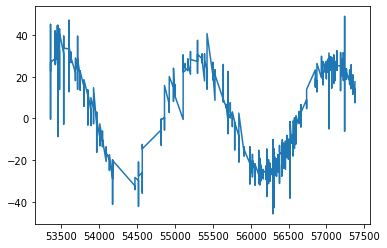

In [7]:
plt.plot(psrs[0].toas/86400, psrs[0].residuals/1e-6)

In [9]:
# white noise parameter
efac = parameter.Constant()
selection = selections.Selection(selections.by_backend)
# white noise signal
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)

In [10]:
#Eccentric gw parameters
#gw parameters
gwphi = parameter.Constant(5.02)('gwphi') #RA of source
gwtheta = parameter.Constant(2.51)('gwtheta') #DEC of source
log10_dist = parameter.Constant(6.0)('log10_dist') #distance to source

#orbital parameters
l0 = parameter.Constant(0)('l0') #mean anomaly
gamma0 = parameter.Constant(0)('gamma0') #initial angle of periastron
inc = parameter.Constant(np.pi/3)('inc') #inclination of the binary's orbital plane
psi = parameter.Constant(0)('psi') #polarization of the GW

#Search parameters
q = parameter.Uniform(0.1,1)('q') #mass ratio
log10_mc = parameter.Uniform(7,11)('log10_mc') #log10 chirp mass
e0 = parameter.Uniform(0.001, 0.1)('e0') #eccentricity
log10_forb = parameter.Uniform(-9,-7)('log10_forb') #log10 orbital frequency
p_dist = parameter.Normal(0,1) #prior on pulsar distance
pphase = parameter.Uniform(0,2*np.pi) #prior on pulsar phase


In [11]:
#Eccentric signal construction
#To create a signal to be used by enterprise you must first create a residual 
#and use CWSignal to convert the residual as part of the enterprise Signal class
ewf = ecc_res.add_ecc_cgw(gwtheta=gwtheta, gwphi=gwphi, log10_mc=log10_mc, q=q, log10_forb=log10_forb, e0=e0, l0=l0, gamma0=gamma0, 
                    inc=inc, psi=psi, log10_dist=log10_dist, p_dist=p_dist, pphase=pphase, gamma_P=None, tref=59000, 
                    psrterm=True, evol=True, waveform_cal=True, res='Both')
ew = CWSignal(ewf, ecc=False, psrTerm=False)


In [12]:
# linearized timing model
tm = gp_signals.TimingModel(use_svd=False)
# full signal (no red noise added at this time)
s = ef + tm + ew

In [13]:
# initialize PTA
model = [s(psr) for psr in psrs]
pta = signal_base.PTA(model)

In [14]:
#add noise parameters to the pta object
params = {}
for nf in noisefiles:
    params.update(get_noise_from_pal2(nf))
pta.set_default_params(params)

{'B1855+09_430_PUPPI_efac': 1.11896,
 'B1855+09_L-wide_PUPPI_efac': 1.38104,
 'B1855+09_430_ASP_efac': 1.16587,
 'B1855+09_L-wide_ASP_efac': 1.08538,
 'J0030+0451_430_PUPPI_efac': 1.10265,
 'J0030+0451_430_ASP_efac': 1.17865,
 'J0030+0451_L-wide_PUPPI_efac': 1.11973,
 'J0030+0451_L-wide_ASP_efac': 1.15368,
 'J0613-0200_Rcvr1_2_GUPPI_efac': 1.07904,
 'J0613-0200_Rcvr1_2_GASP_efac': 1.05557,
 'J0613-0200_Rcvr_800_GASP_efac': 1.09774,
 'J0613-0200_Rcvr_800_GUPPI_efac': 1.16631,
 'J1012+5307_Rcvr_800_GASP_efac': 1.13901,
 'J1012+5307_Rcvr1_2_GUPPI_efac': 1.0814,
 'J1012+5307_Rcvr1_2_GASP_efac': 1.05488,
 'J1012+5307_Rcvr_800_GUPPI_efac': 1.18258,
 'J1024-0719_Rcvr_800_GASP_efac': 0.981372,
 'J1024-0719_Rcvr_800_GUPPI_efac': 1.11307,
 'J1024-0719_Rcvr1_2_GASP_efac': 0.912666,
 'J1024-0719_Rcvr1_2_GUPPI_efac': 1.07663,
 'J1455-3330_Rcvr_800_GUPPI_efac': 1.25385,
 'J1455-3330_Rcvr1_2_GASP_efac': 1.11027,
 'J1455-3330_Rcvr_800_GASP_efac': 1.30957,
 'J1455-3330_Rcvr1_2_GUPPI_efac': 1.1647,
 'J1

In [16]:
pta.params

[B1855+09_cw_p_dist:Normal(mu=0, sigma=1),
 B1855+09_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J0030+0451_cw_p_dist:Normal(mu=0, sigma=1),
 J0030+0451_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J0613-0200_cw_p_dist:Normal(mu=0, sigma=1),
 J0613-0200_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1012+5307_cw_p_dist:Normal(mu=0, sigma=1),
 J1012+5307_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1024-0719_cw_p_dist:Normal(mu=0, sigma=1),
 J1024-0719_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1455-3330_cw_p_dist:Normal(mu=0, sigma=1),
 J1455-3330_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1600-3053_cw_p_dist:Normal(mu=0, sigma=1),
 J1600-3053_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1640+2224_cw_p_dist:Normal(mu=0, sigma=1),
 J1640+2224_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1744-1134_cw_p_dist:Normal(mu=0, sigma=1),
 J1744-1134_cw_pphase:Uniform(pmin=0, pmax=6.283185307179586),
 J1909-3744_cw_p_dist:Normal(mu=

In [17]:
#Select sample from the search parameters
xecc = np.hstack(np.array([p.sample() for p in pta.params]))
ndim = len(xecc)

In [18]:
xecc

array([-1.60372024,  2.34711445,  1.56721571,  2.45008715,  0.39905133,
        4.11622657, -0.18248397,  1.07573464, -0.64656102,  1.26751308,
       -1.48996216,  0.6823178 ,  0.84495744,  3.13906729, -0.07639842,
        0.85530818,  0.54736892,  1.73814307,  0.25326863,  3.31090049,
        0.0432667 , -7.29472743,  8.23442383,  0.96704857])

In [19]:
#testing to see if we get a likelihood value
pta.get_lnlikelihood(xecc)

-27679154.490259826

In [20]:
# initialize pulsar distance parameters
p_dist_params = [ p for p in pta.param_names if 'p_dist' in p ]
for pd in p_dist_params:
    xecc[pta.param_names.index(pd)] = 0

In [21]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

In [22]:
#groups = [range(0, 24), [19,20], [20,21], [2,3]]
groups = [range(0, 24), [20,21],[20,22], [21,22], [22,23]]

In [24]:
#output directory for all the chains, params, and groups
chaindir = '../ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source3/run1/'

In [25]:
np.shape(cov)

(24, 24)

In [26]:

resume = True
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups,
                 outDir=chaindir, resume=resume)

# write parameter file and parameter groups file
np.savetxt(chaindir + 'params.txt', list(map(str, pta.param_names)), fmt='%s')
np.savetxt(chaindir + 'groups.txt', groups, fmt='%s')

/home/bcheeseboro/anaconda3/envs/enterprise/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
# add prior draws to proposal cycle
jp = JP(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 25)

In [28]:
N = int(1.5e6)

In [29]:
sampler.sample(xecc, N, SCAMweight=40, AMweight=20, DEweight=60)

Resuming run from chain file ../ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source3/run1//chain_1.txt


/home/bcheeseboro/anaconda3/envs/enterprise/lib/python3.8/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.67 percent in 346.206497 s Acceptance rate = 0.0663934Adding DE jump with weight 60
Finished 41.33 percent in 53254.111424 s Acceptance rate = 0.0792144

ZeroDivisionError: float division by zero